In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import sklearn
#baseline linear regression
from sklearn import linear_model
#import sklearn.linear_model
#normalization
from sklearn import preprocessing
#train/test split
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
#metrics
from sklearn.metrics import mean_absolute_error

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [2]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
df1 = pd.read_csv(r'..\Zillow\properties_2016.csv')
print(df1.shape)
df2 = pd.read_csv(r'..\Zillow\train_2016_v2.csv')
print(df2.shape)


C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(90275, 3)


In [24]:
#df2[df2.transactiondate >= '2016-10-15']
df2[df2.transactiondate < '2016-10-15'].shape
#max(df2.transactiondate)

(85670, 3)

In [3]:
df_train = df2.merge(df1, how='left', on='parcelid')

#revisit this fillna
df_train = df_train.fillna(0)

df_train['taxdelinquencyflag'] = df_train.taxdelinquencyflag.apply(lambda x: 1 if x == 'Y' else 0 )
df_train['fireplaceflag'] = df_train.hashottuborspa.astype(int)
df_train['hashottuborspa'] = df_train.hashottuborspa.astype(int)

#use all old data for training
#split the new data, 50% train, 50% dev
df_train_1 = df_train[df_train.transactiondate < '2016-10-15']
df_train_2 = df_train[df_train.transactiondate >= '2016-10-15']

train_index, dev_index = train_test_split(df_train_2.index, test_size=0.5, random_state=0)
df_train = pd.concat([df_train_1, df_train_2.loc[train_index]])
df_dev = df_train_2.loc[dev_index]

y_train = df_train.logerror.values
y_dev = df_dev.logerror.values

df_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
df_dev = df_dev.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

X_train = df_train.values
X_dev = df_dev.values

print(X_train.shape)
print(X_dev.shape)

(87972, 55)
(2303, 55)


In [4]:
#normalization - mean, var from train set, apply to dev set and test set
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)   
X_dev = scaler.transform(X_dev)

X_train_k = X_train
X_dev_k = X_dev
Y_train_k = y_train.reshape(y_train.shape[0], 1)
Y_dev_k = y_dev.reshape(y_dev.shape[0], 1)

X_train_my = X_train.T
X_dev_my = X_dev.T
Y_train_my = y_train.reshape(1, y_train.shape[0])
Y_dev_my = y_dev.reshape(1, y_dev.shape[0])



In [9]:
np.random.seed(0) # set a seed so that the results are consistent
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
print(mean_absolute_error(y_train, y_pred))
y_pred = regr.predict(X_dev)
print(mean_absolute_error(y_dev, y_pred))

0.0683074122879
0.0710661821951


In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['mean_absolute_error'], logs['val_mean_absolute_error']) 

In [30]:
np.random.seed(0)
model = Sequential()

initializer = keras.initializers.he_normal()

regularizer = None

model.add(Dense(50, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(50, kernel_initializer=initializer, activation='relu'))
#model.add(Dense(20, kernel_initializer=initializer, activation='relu'))
model.add(Dense(1, kernel_initializer=initializer))

#optimizer = optimizers.SGD(lr=0.05, momentum=0.9)
optimizer = optimizers.RMSprop(lr=0.01)
#optimizer = optimizers.Adam(lr=0.001)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])


In [31]:
initial_epoch = 0
epochs = 500
verbose = 0
verbose2 = 50
#batch_size = int(X_train_k.shape[0])
batch_size = 512

results_k = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)

Y_predict_k = model.predict(X_train_k)
print(mean_absolute_error(Y_train_k, Y_predict_k))
Y_predict_k = model.predict(X_dev_k)
print(mean_absolute_error(Y_dev_k, Y_predict_k))

0 0.116272117748 0.121701615085 0.0720374088765
50 0.0257702976771 0.0690168988679 0.0711153982368
100 0.025665524188 0.0688677888079 0.0735601947242
150 0.0255887467469 0.0687911045586 0.0756005935057
200 0.0256257741603 0.0687590536972 0.0747333967583
250 0.0256500992285 0.0687307666125 0.0774121463066
300 0.025638218774 0.0688018048489 0.0731009556497
350 0.0256386346951 0.0686931318555 0.0711402551045
400 0.0256402699973 0.0687299505281 0.0722060111965
450 0.0255532973614 0.068677921679 0.0720368071556
0.0678923593588
0.0762792523986


In [ ]:
50/20/20/1 lr=0.05/epochs=1000/batch_size=all
0.068418922444
0.0707010474982

50/20/20/1 lr=0.05/epochs=1000/batch_size=256 - perf degraded with batch
0.0713863738691
0.0779876377184

50/20/20/1 lr=0.05/epochs=1000/batch_size=256/beta=0.9
0.0671880892364
0.0776223449845

50/20/20/1 lr=0.05/epochs=1000/batch_size=256/adam
0.0695408259363
0.0711735808051

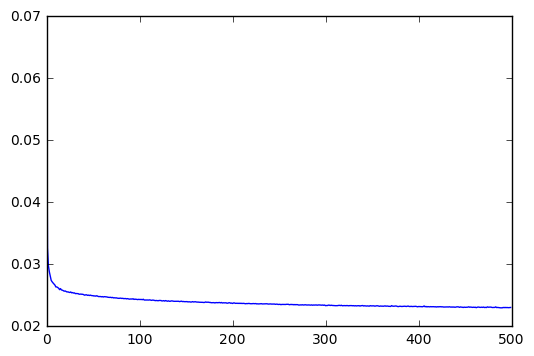

In [27]:
plt.plot(results_k.history['loss'])
plt.show()

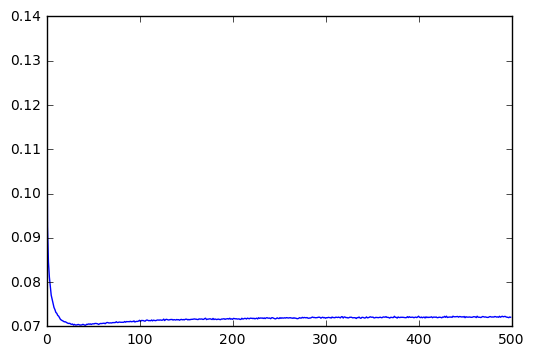

In [28]:
plt.plot(results_k.history['mean_absolute_error'])
plt.show()

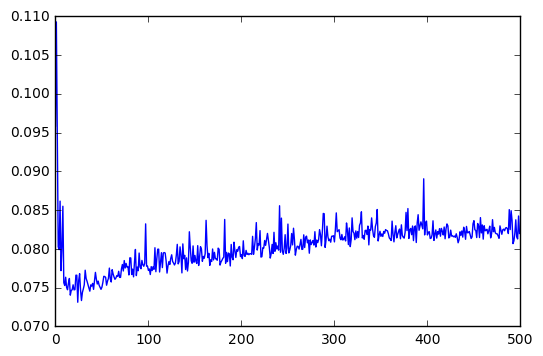

In [29]:
plt.plot(results_k.history['val_mean_absolute_error'])
plt.show()

In [41]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [114]:
#random seed for parameters init and mini batch shuffle
np.random.seed(0)
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(100, DNN.relu)
dnn.add_layer(20, DNN.relu)
#dnn.add_layer(20, DNN.relu)
dnn.add_layer(1, DNN.identity)
dnn.costfunction = DNN.mean_squared_error
dnn.init = 'He'
dnn.optimizer = 'Adam'
dnn.compile()

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_my = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, epochs=0)

Cost after iteration 0 ['0.066431', '0.070219', '0.073271']
0.0689874931275
0.0720098978679


In [115]:
learning_rate = 0.005
epochs = 5000
batch_size = 512
gradient_check=False
verbose = 100

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_tmp = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='mae', learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, gradient_check=gradient_check, verbose=verbose)
Y_predict_my = dnn.predict(X_train_my)
print(mean_absolute_error(np.reshape(Y_train_my, Y_train_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))
Y_predict_my = dnn.predict(X_dev_my)
print(mean_absolute_error(np.reshape(Y_dev_my, Y_dev_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))

results_my['loss'] += results_tmp['loss']
results_my['eval0'] += results_tmp['eval0']
results_my['eval1'] += results_tmp['eval1']

Cost after iteration 0 ['0.025830', '0.068642', '0.071827']
Cost after iteration 100 ['0.024210', '0.067476', '0.071785']
Cost after iteration 200 ['0.023437', '0.067101', '0.072506']
Cost after iteration 300 ['0.022937', '0.067592', '0.073650']
Cost after iteration 400 ['0.022765', '0.066954', '0.072160']
Cost after iteration 500 ['0.022679', '0.067140', '0.072108']
Cost after iteration 600 ['0.022387', '0.067362', '0.072963']
Cost after iteration 700 ['0.022334', '0.067127', '0.074150']
Cost after iteration 800 ['0.022359', '0.066618', '0.073572']
Cost after iteration 900 ['0.022242', '0.066622', '0.074974']
Cost after iteration 1000 ['0.022542', '0.066115', '0.074842']
Cost after iteration 1100 ['0.022292', '0.066495', '0.075103']
Cost after iteration 1200 ['0.022370', '0.066425', '0.074386']
Cost after iteration 1300 ['0.022568', '0.066744', '0.073787']
Cost after iteration 1400 ['0.022636', '0.066797', '0.074070']
Cost after iteration 1500 ['0.022545', '0.066307', '0.076923']
Cost

In [ ]:
50/20/20/1 lr=0.05/epochs=1000/batch_size=256/beta=0.9

0.0701979917931
0.0771326500504

50/20/20/1 lr=0.05/epochs=1000/batch_size=256/adam
0.0688845282311
0.0708512572053

100/20/1 lr=0.005/epochs=500/batch_size=512/adam
0.0683652282659
0.0717688283095

5500
0.0653762805808
0.0730314887008

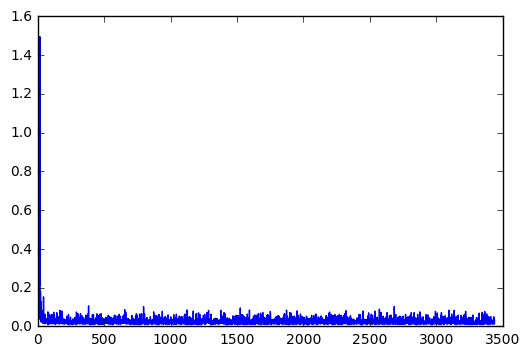

In [108]:
plt.plot(results_my['loss'])
plt.show()

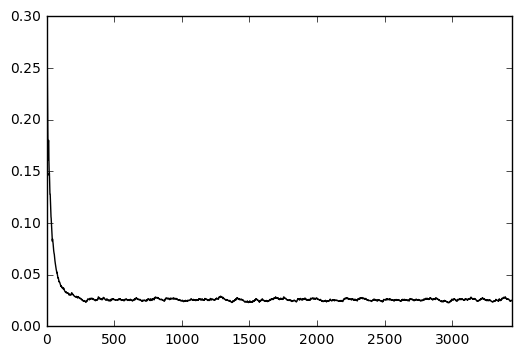

In [109]:
df_loss = pd.DataFrame(results_my['loss'])
df_loss[df_loss[0] > 0.5] = df_loss[0].mean()
#df_loss[0].plot()
df_loss[0].ewm(span=100).mean().plot(style='k')

In [110]:
df_loss[0].describe()

count    3440.000000
mean        0.026892
std         0.020173
min         0.007136
25%         0.016224
50%         0.022834
75%         0.031815
max         0.490886
Name: 0, dtype: float64

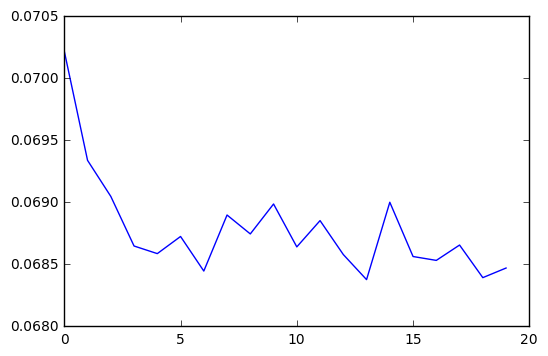

In [111]:
plt.plot(results_my['eval0'])
plt.show()

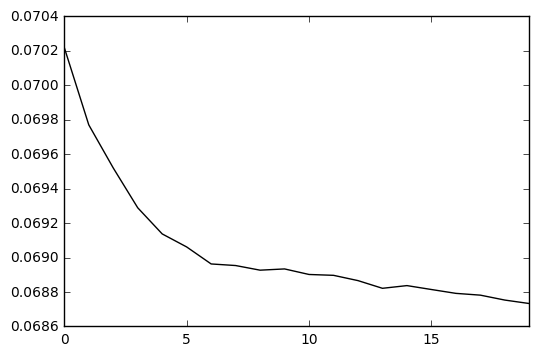

In [112]:
df_eval0 = pd.DataFrame(results_my['eval0'])
df_eval0[0].ewm(span=50).mean().plot(style='k')

In [113]:
df_eval0[0].describe()

count    20.000000
mean      0.068786
std       0.000418
min       0.068378
25%       0.068556
50%       0.068653
75%       0.068921
max       0.070219
Name: 0, dtype: float64

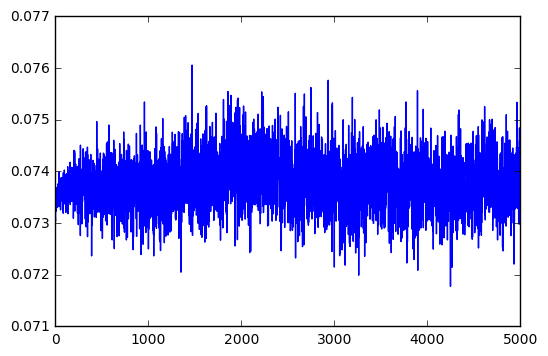

In [95]:
plt.plot(results_my['eval1'])

In [94]:
len(results_my['eval1'])

5000